This is a dataset for classifying patients based on various measurements (biosignals). The dataset is available at the following link:
https://www.kaggle.com/competitions/playground-series-s3e24/data

The project objectives can be found here: https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals, as our dataset was created based on the one linked above.

According to the dataset creators, many physicians have stopped counseling patients on quitting smoking due to its perceived ineffectiveness. In particular, many patients returned to smoking despite receiving professional advice. To address this issue, it was proposed to train a model that could identify features distinguishing smokers from non-smokers. This would allow healthcare providers to better identify patients who are more likely to successfully quit smoking.

The dataset includes the following features: age, height (cm), weight (kg), waist circumference (cm), vision (left and right eye), hearing (left and right ear), blood pressure (systolic and diastolic), fasting blood glucose level, cholesterol (total, LDL, and HDL), triglycerides, hemoglobin, urine protein, serum creatinine, AST, ALT, GTP (gamma-glutamyl transpeptidase), and presence of dental caries.

The target variable is smoking status (0 - non-smoker, 1 - smoker).

**First, we will conduct an exploratory analysis of the dataset.**

In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [370]:
df = pd.read_csv("train.csv", index_col='id')

**Here, we will also set aside the raw data to build a baseline model.**

In [373]:
raw_df = df.copy()

In [375]:
raw_X_train = raw_df.drop(columns = ['smoking'])
raw_y_train = raw_df['smoking']

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(raw_X_train, raw_y_train, test_size = 0.2, random_state = 42)

In [611]:
df_test = pd.read_csv("test.csv", index_col='id')
raw_df_test = df_test.copy()

In [379]:
raw_model = LogisticRegression(solver='liblinear', random_state=42)

In [381]:
raw_model.fit(X_raw_train, y_raw_train)
raw_y_train_pred = raw_model.predict(X_raw_test)

**Performance metrics of the baseline model on the raw test data**

In [383]:
raw_accuracy = accuracy_score(y_raw_test, raw_y_train_pred)
raw_precision = precision_score(y_raw_test, raw_y_train_pred)
raw_recall = recall_score(y_raw_test, raw_y_train_pred)
raw_f1 = f1_score(y_raw_test, raw_y_train_pred)
raw_roc_auc = roc_auc_score(y_raw_test, raw_model.predict_proba(X_raw_test)[:, 1])

print(f'Accuracy for raw DataFrame: {raw_accuracy}')
print(f'Precision for raw DataFrame: {raw_precision}')
print(f'Recall for raw DataFrame: {raw_recall}')
print(f'F1 Score for raw DataFrame: {raw_f1}')
print(f'ROC AUC for raw DataFrame: {raw_roc_auc}')

Accuracy for raw DataFrame: 0.7454163003893005
Precision for raw DataFrame: 0.7036353696870302
Recall for raw DataFrame: 0.731892813988201
F1 Score for raw DataFrame: 0.717485977075567
ROC AUC for raw DataFrame: 0.8322575753891877


In [384]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin           1

In [385]:
print(df.describe()) 

                 age     height(cm)     weight(kg)      waist(cm)  \
count  159256.000000  159256.000000  159256.000000  159256.000000   
mean       44.306626     165.266929      67.143662      83.001990   
std        11.842286       8.818970      12.586198       8.957937   
min        20.000000     135.000000      30.000000      51.000000   
25%        40.000000     160.000000      60.000000      77.000000   
50%        40.000000     165.000000      65.000000      83.000000   
75%        55.000000     170.000000      75.000000      89.000000   
max        85.000000     190.000000     130.000000     127.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count   159256.000000    159256.000000  159256.000000   159256.000000   
mean         1.005798         1.000989       1.023974        1.023421   
std          0.402113         0.392299       0.152969        0.151238   
min          0.100000         0.100000       1.000000        1.000000   
25%          

In [386]:
print(df.columns) 

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')


**Let's examine the DataFrame for missing values and duplicates**

In [388]:
def duplicates_nan(df, is_train=True):
    print(f'Number of features with missing values: {df.isnull().any().sum()}')
    print(f'Total number of missing values: {df.isnull().values.sum()}')
    
    zero_rows = df[(df == 0).all(axis=1)]
    print(f'Number of all-zero rows: {zero_rows.shape[0]}')
    
    duplicates = df[df.duplicated()]
    print(f'Duplicated rows:\n{duplicates}')
    
    df = df[~(df == 0).all(axis=1)]

    if df.isnull().values.sum() > 0:
        df = df.dropna(how='any')

    if df.duplicated().sum() > 0:
        df = df.drop_duplicates(keep='first')
    
    return df

df = duplicates_nan(df)

Number of features with missing values: 0
Total number of missing values: 0
Number of all-zero rows: 0
Duplicated rows:
Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, smoking]
Index: []

[0 rows x 23 columns]


In [389]:
print(df.shape)

(159256, 23)


**There are no duplicates or missing values.**

**Split the training set into features and target variable.**

In [392]:
X_train =df.drop(columns = ['smoking'])
y_train = df['smoking']

**Split the training dataset into training and validation sets.**

In [580]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify=y_train)

In [595]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

**Display the correlation heatmap to check which features have a high degree of correlation**

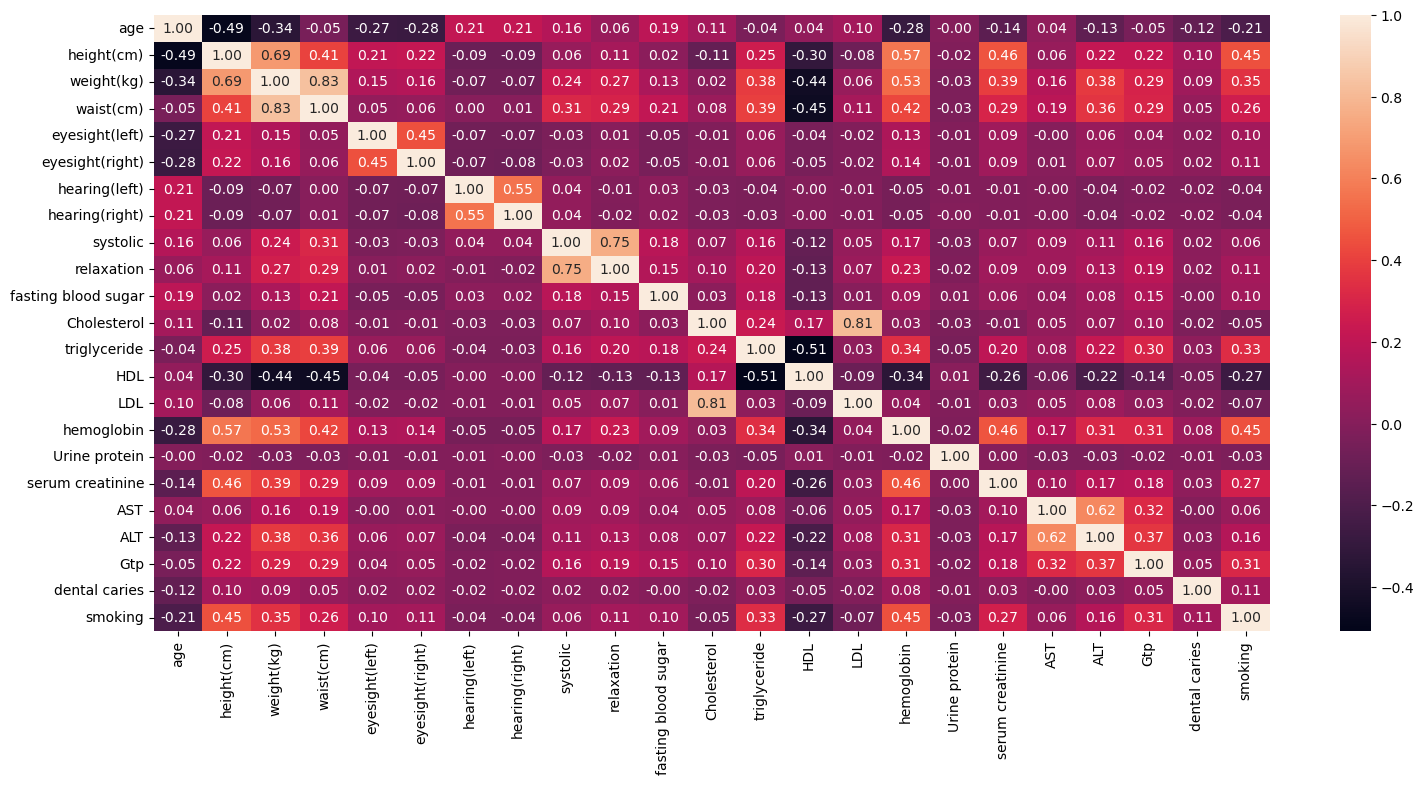

In [598]:
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.savefig('corr.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
None

It seems there is correlation between height, hemoglobin and the target feature, but there is noticeable correlation between some input features (such as weight and waist) as well. Therefore, it might make sense to either apply dimensionality reduction techniques like PCA, or use models that are robust to multicollinearity, such as tree-based methods (e.g., Random Forest, XGBoost, or LightGBM)

**Mutual information test**

**Here we select the parameter score_func=mutual_info_classif, which also takes into account complex nonlinear relationships.**

In [402]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

bestfeature = SelectKBest(score_func=mutual_info_classif)
bestfeature.fit(X_train, y_train)
sc = bestfeature.scores_
impt_feature = pd.DataFrame({"Feature":X_train.columns,"Score":sc})
impt_feature = impt_feature.sort_values(by="Score",ascending=False)
print(impt_feature)

                Feature     Score
1            height(cm)  0.140051
15           hemoglobin  0.137364
20                  Gtp  0.101796
2            weight(kg)  0.081340
12         triglyceride  0.077247
17     serum creatinine  0.062922
3             waist(cm)  0.043880
13                  HDL  0.040137
19                  ALT  0.030607
0                   age  0.027028
5       eyesight(right)  0.015074
7        hearing(right)  0.014805
9            relaxation  0.013577
6         hearing(left)  0.012869
16        Urine protein  0.012636
8              systolic  0.012346
4        eyesight(left)  0.012115
10  fasting blood sugar  0.009947
14                  LDL  0.009212
11          Cholesterol  0.008056
21        dental caries  0.007372
18                  AST  0.003510


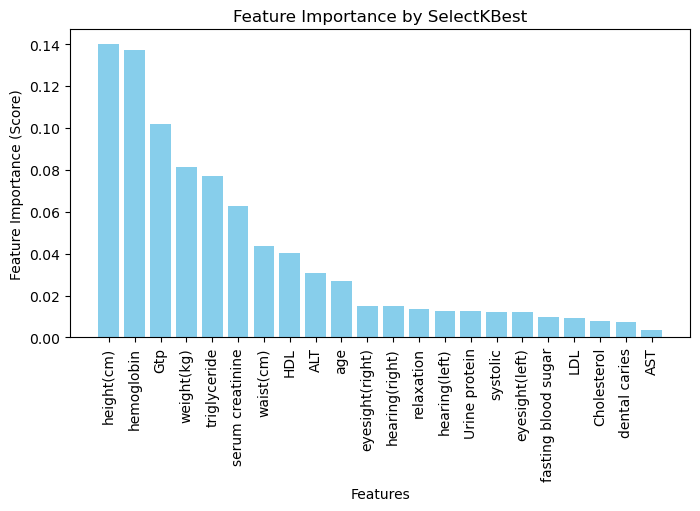

In [403]:
plt.figure(figsize=(8, 4))
plt.bar(impt_feature["Feature"], impt_feature["Score"], color="skyblue")

plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance (Score)")
plt.title("Feature Importance by SelectKBest")

plt.show()


**The variables most correlated with the target variable are as follows: height, weight, waist circumference, triglycerides, hemoglobin, creatinine, and GTP. However, the degree of correlation is low.**

**For some features, we will create polynomial features to later test whether they improve the metrics**

**In the next steps, we will demonstrate the metrics of models trained on the dataset with the included features listed below.**



Let's add polynomial features based on the original data:

Body Mass Index (BMI);

Waist-to-Height ratio;

Cholesterol ratio (HDL cholesterol to LDL cholesterol).

In [420]:
X_train['BMI'] = X_train['weight(kg)'] / ((X_train['height(cm)'] / 100) **2)
X_train['waist_height_ratio'] = X_train['waist(cm)'] / X_train['height(cm)']
X_train['chol_ratio'] = X_train['LDL'] / X_train['HDL']

In [423]:
#We will also add these features to the DataFrame, 
#which will later be cleaned from outliers. 
#It will be determined later that the outlier removal did not improve the metrics, 
#but this step has been preserved in the research history.


# df_cleaned_from_outliers = df.copy() 

# df_cleaned_from_outliers['BMI'] = df_cleaned_from_outliers['weight(kg)'] / ((df_cleaned_from_outliers['height(cm)'] / 100) **2)
# df_cleaned_from_outliers['waist_height_ratio'] = df_cleaned_from_outliers['waist(cm)'] / df_cleaned_from_outliers['height(cm)']
# df_cleaned_from_outliers['chol_ratio'] = df_cleaned_from_outliers['LDL'] / df_cleaned_from_outliers['HDL']

Let's check the obtained values:

In [426]:
print(X_train[['BMI', 'waist_height_ratio', 'chol_ratio']].describe())

                 BMI  waist_height_ratio     chol_ratio
count  127404.000000       127404.000000  127404.000000
mean       24.457998            0.502533       2.184253
std         3.366741            0.050081       0.745337
min        11.718750            0.309091       0.021739
25%        22.222222            0.468571       1.653846
50%        24.221453            0.500000       2.146341
75%        26.234568            0.535294       2.660377
max        45.785640            0.785714      29.756098


**Let's see what values are observed in the features**

In [429]:
X_train.head()


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
140917,45,160,75,95.0,1.5,0.9,1,1,154,94,...,16.7,1,0.8,26,36,43,0,29.296875,0.593750,2.710526
133861,35,175,85,95.0,1.2,1.2,1,1,110,70,...,15.6,1,1.0,29,43,38,0,27.755102,0.542857,2.945946
50644,45,170,70,84.0,0.7,0.8,1,1,125,79,...,13.5,1,1.0,19,17,23,0,24.221453,0.494118,2.666667
70720,50,155,50,65.0,0.9,0.5,1,1,131,78,...,12.4,1,0.8,25,21,11,0,20.811655,0.419355,1.900000
121903,60,160,60,75.0,0.6,0.5,1,1,164,100,...,14.7,1,0.9,23,11,25,0,23.437500,0.468750,2.181818


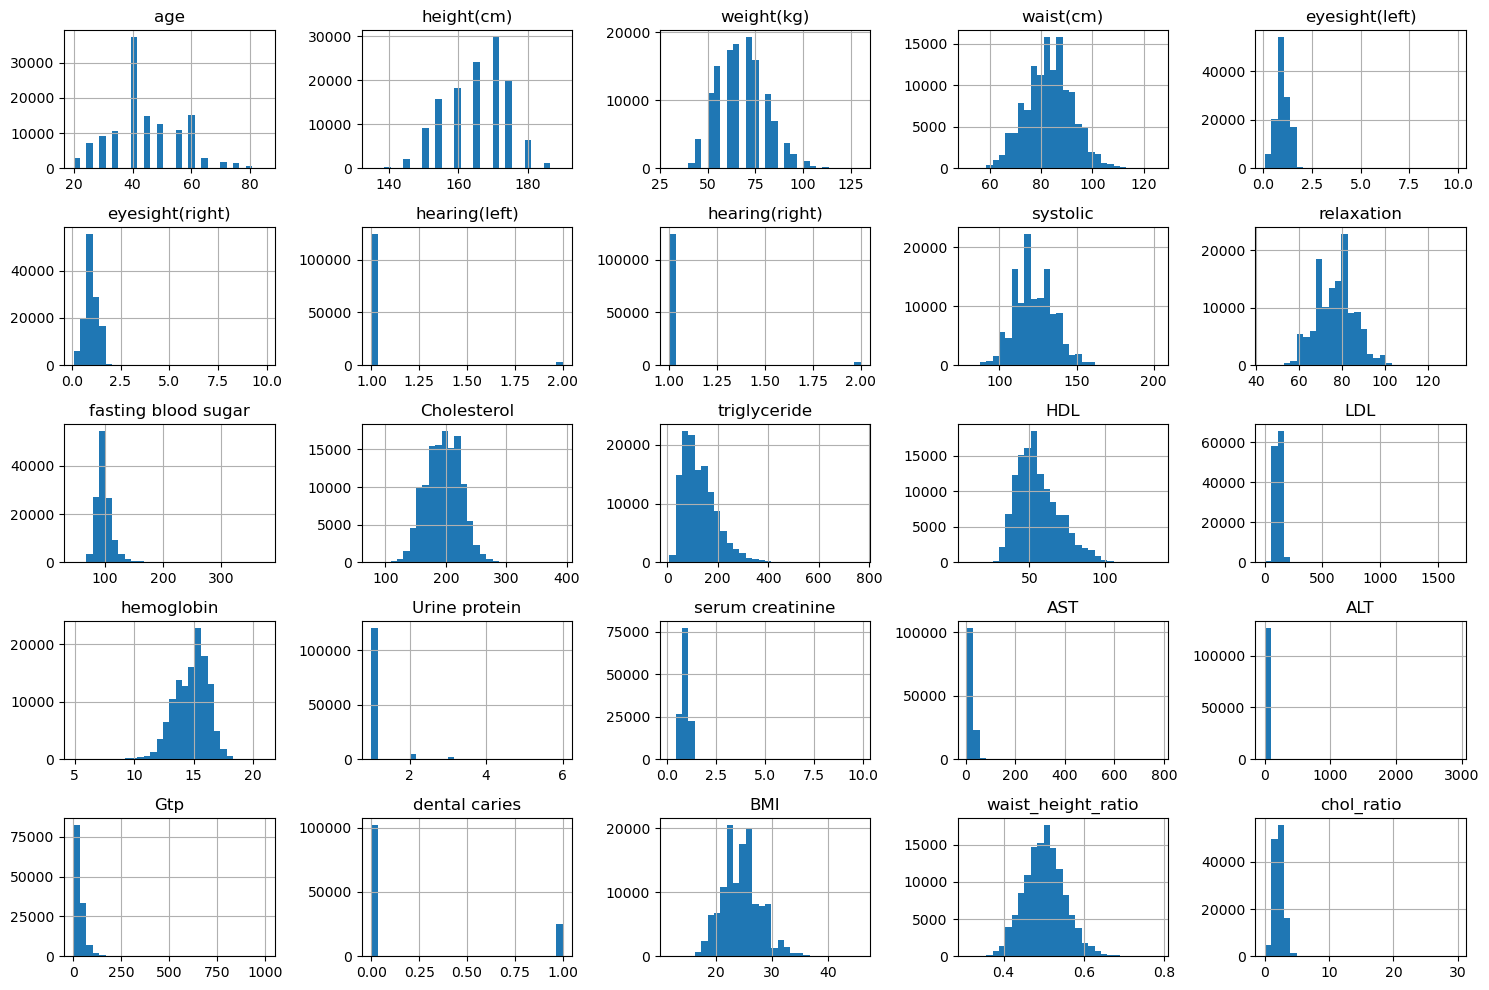

In [431]:
X_train.hist(bins=30, figsize=(15, 10))
plt.tight_layout() 
None

**We found that some features have values of small natural numbers. Let's examine which values appear for these features to determine if they have a binary structure.**

In [433]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
1    124355
2      3049
Name: count, dtype: int64
hearing(right)
1    124427
2      2977
Name: count, dtype: int64
Urine protein
1    120690
2      4500
3      1762
4       387
5        61
6         4
Name: count, dtype: int64
dental caries
0    102099
1     25305
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
140917,45,160,75,95.0,1.5,0.9,1,1,154,94,...,16.7,1,0.8,26,36,43,0,29.296875,0.593750,2.710526
133861,35,175,85,95.0,1.2,1.2,1,1,110,70,...,15.6,1,1.0,29,43,38,0,27.755102,0.542857,2.945946
50644,45,170,70,84.0,0.7,0.8,1,1,125,79,...,13.5,1,1.0,19,17,23,0,24.221453,0.494118,2.666667
70720,50,155,50,65.0,0.9,0.5,1,1,131,78,...,12.4,1,0.8,25,21,11,0,20.811655,0.419355,1.900000
121903,60,160,60,75.0,0.6,0.5,1,1,164,100,...,14.7,1,0.9,23,11,25,0,23.437500,0.468750,2.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135731,35,170,75,89.0,1.0,0.9,1,1,122,80,...,15.9,1,0.9,24,28,39,1,25.951557,0.523529,2.391304
83321,50,150,40,65.0,1.2,1.2,1,1,97,60,...,13.3,1,0.5,18,13,8,0,17.777778,0.433333,1.816327
151730,55,170,75,91.0,1.2,1.0,1,1,140,90,...,16.3,1,1.0,25,24,44,0,25.951557,0.535294,2.500000


Thus, hearing and cavities are essentially encoded binary categorical variables.

**At the same time, some inconsistency is observed, as the classification in the hearing columns is done on a 1/2 basis, rather than 0/1 as in the "cavities" or "smoking" columns. Therefore, a decision was made to change the encoding to 0/1.**

**Additionally, the column with protein content in urine contains a gradation of values from 1 to 6, which also indicates that the variable is categorical.**

We assume that 1 represents either absolute or relative absence of protein in the urine (clinically insignificant amount detected). Therefore, it seems reasonable to recode this column to a range of 0-5.

Recoding is necessary in this case to ensure model prediction stability, as differences in classification principles could lead to a deterioration in model quality.

**Let's recode the above mentioned features**

In [438]:
columns_recoding = ['hearing(left)', 'hearing(right)', 'Urine protein']
def recoding(dataframe, is_train=True):
    for column in columns_recoding:
        dataframe[column] = dataframe[column] - 1
    return dataframe
X_train = recoding(X_train)
    

In [440]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
0    124355
1      3049
Name: count, dtype: int64
hearing(right)
0    124427
1      2977
Name: count, dtype: int64
Urine protein
0    120690
1      4500
2      1762
3       387
4        61
5         4
Name: count, dtype: int64
dental caries
0    102099
1     25305
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
140917,45,160,75,95.0,1.5,0.9,0,0,154,94,...,16.7,0,0.8,26,36,43,0,29.296875,0.593750,2.710526
133861,35,175,85,95.0,1.2,1.2,0,0,110,70,...,15.6,0,1.0,29,43,38,0,27.755102,0.542857,2.945946
50644,45,170,70,84.0,0.7,0.8,0,0,125,79,...,13.5,0,1.0,19,17,23,0,24.221453,0.494118,2.666667
70720,50,155,50,65.0,0.9,0.5,0,0,131,78,...,12.4,0,0.8,25,21,11,0,20.811655,0.419355,1.900000
121903,60,160,60,75.0,0.6,0.5,0,0,164,100,...,14.7,0,0.9,23,11,25,0,23.437500,0.468750,2.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135731,35,170,75,89.0,1.0,0.9,0,0,122,80,...,15.9,0,0.9,24,28,39,1,25.951557,0.523529,2.391304
83321,50,150,40,65.0,1.2,1.2,0,0,97,60,...,13.3,0,0.5,18,13,8,0,17.777778,0.433333,1.816327
151730,55,170,75,91.0,1.2,1.0,0,0,140,90,...,16.3,0,1.0,25,24,44,0,25.951557,0.535294,2.500000


**Recoding completed successfully**

**Next, let's see if there are any outliers.**

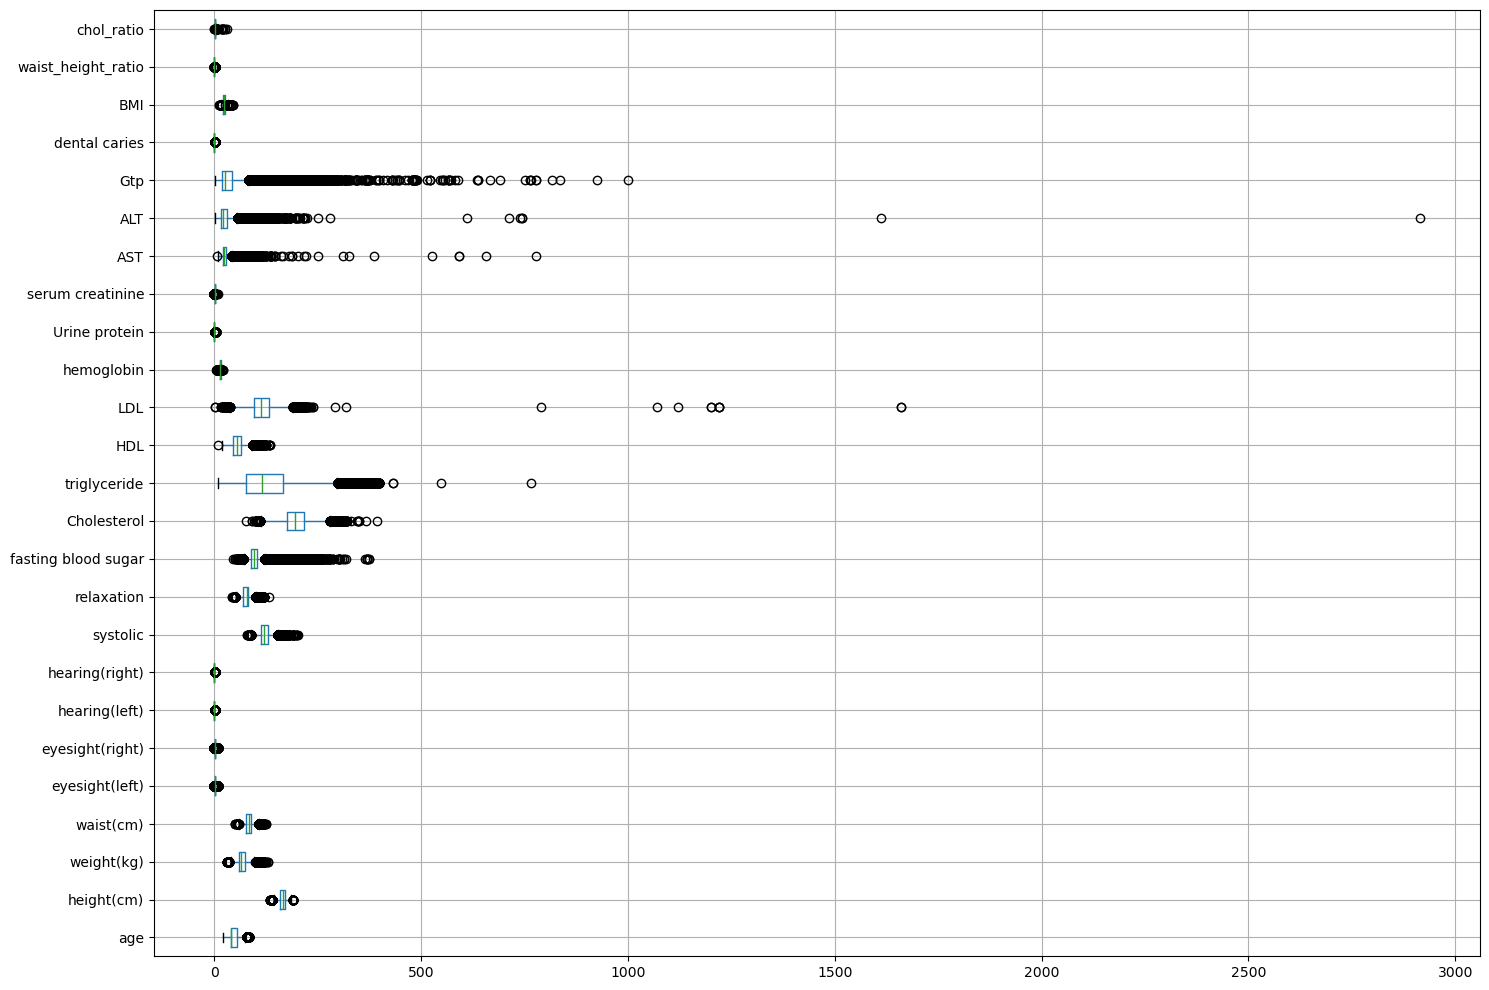

In [444]:
X_train.boxplot(figsize=(15, 10), vert=False)
plt.tight_layout()

**There are outliers. We will use the IQR method to identify and subsequently remove outliers, but it will later become clear that this does not improve the model. Therefore, this part is kept only for the record.**

In [447]:
# columns_with_outliers = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
#        'eyesight(right)', 'systolic',
#        'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
#        'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
#        'ALT', 'Gtp', 'BMI', 'waist_height_ratio', 'chol_ratio']  

# df_cleaned_from_outliers = df_cleaned_from_outliers.copy()  

# for column in columns_with_outliers:
#     Q1 = df_cleaned_from_outliers.loc[:, column].quantile(0.25)  
#     Q3 = df_cleaned_from_outliers.loc[:, column].quantile(0.75)  
#     IQR = Q3 - Q1  
#     lower_bound = Q1 - 1.5 * IQR  
#     upper_bound = Q3 + 1.5 * IQR  
    
#     df_cleaned_from_outliers.loc[:, f'{column}_IQR_Outlier'] = (df_cleaned_from_outliers[column] < lower_bound) | (df_cleaned_from_outliers[column] > upper_bound)
    
#     outliers_number = df_cleaned_from_outliers[f'{column}_IQR_Outlier'].value_counts().get(True, 0)
#     print(f'Outlier values in column {column}: {outliers_number}')

#     df_cleaned_from_outliers = df_cleaned_from_outliers[~df_cleaned_from_outliers[f'{column}_IQR_Outlier']]  
    
#     df_cleaned_from_outliers.drop(columns=[f'{column}_IQR_Outlier'], inplace=True)

# print(f"Remaining rows in df_cleaned_from_outliers after removing outliers: {df_cleaned_from_outliers.shape[0]}")


**Instead of removing outliers, let's try to apply a logarithmic transformation to these features to make their scale more compact.**

In [451]:
print(X_train.columns)

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'BMI', 'waist_height_ratio',
       'chol_ratio'],
      dtype='object')


        age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
id                                                               
140917   45         160          75       95.0             1.5   
133861   35         175          85       95.0             1.2   
50644    45         170          70       84.0             0.7   
70720    50         155          50       65.0             0.9   
121903   60         160          60       75.0             0.6   
...     ...         ...         ...        ...             ...   
135731   35         170          75       89.0             1.0   
83321    50         150          40       65.0             1.2   
151730   55         170          75       91.0             1.2   
146649   60         160          65       89.0             0.9   
132566   50         160          75       90.0             0.3   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
id                                                           

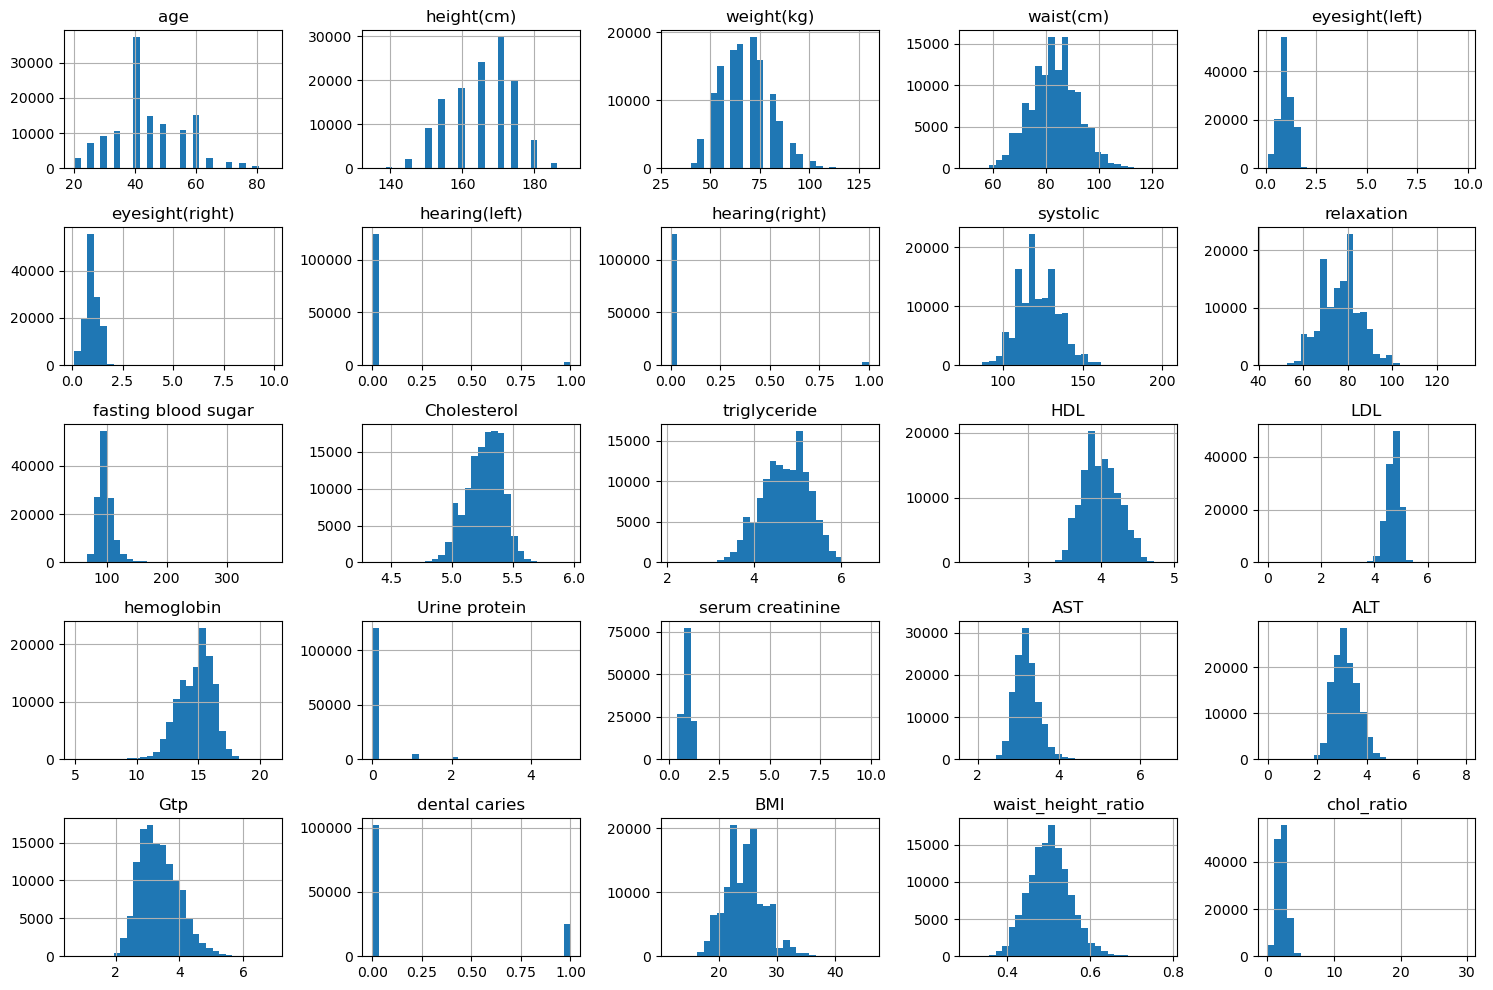

In [453]:
columns_log = ['Cholesterol','triglyceride', 'LDL', 'HDL', 'AST', 'ALT', 'Gtp']
def log_func(dataframe):
    dataframe[columns_log] = dataframe[columns_log].map(lambda x: x if x > 0 else 1) 
    dataframe[columns_log] = np.log(dataframe[columns_log])
    dataframe.hist(bins=30, figsize=(15, 10))
    plt.tight_layout()
    None
    plt.savefig('g.png', dpi=600)
    return dataframe

print(log_func(X_train))

**We can see that the distribution of the features has become normal, more closely resembling a bell-shaped curve**

**Next, we will standardize the values of the numerical variables.**

In [456]:
columns_scale = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'chol_ratio', 'BMI']


In [457]:
scaler = StandardScaler()
X_train[columns_scale] = scaler.fit_transform(X_train[columns_scale])
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
140917,0.057361,-0.596624,0.623520,1.339594,1.217059,-0.257271,0,0,2.473916,1.901922,...,1.331631,0,-0.516901,0.221383,0.875944,0.625661,0,1.437264,0.593750,0.706091
133861,-0.787359,1.105028,1.418060,1.339594,0.477983,0.505916,0,0,-0.984023,-0.766410,...,0.563009,0,0.601868,0.588173,1.233999,0.427430,0,0.979320,0.542857,1.021949
50644,0.057361,0.537811,0.226250,0.111057,-0.753811,-0.511667,0,0,0.194820,0.234214,...,-0.904360,0,0.601868,-0.832164,-0.636037,-0.377739,0,-0.070260,0.494118,0.647245
70720,0.479721,-1.163841,-1.362831,-2.010962,-0.261093,-1.274854,0,0,0.666357,0.123034,...,-1.672982,0,-0.516901,0.089644,-0.210217,-1.560574,0,-1.083053,0.419355,-0.381376
121903,1.324441,-0.596624,-0.568290,-0.894110,-1.000169,-1.274854,0,0,3.259811,2.569006,...,-0.065863,0,0.042484,-0.190427,-1.513270,-0.244026,0,-0.303113,0.468750,-0.003266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135731,-0.787359,0.537811,0.623520,0.669483,-0.014735,-0.257271,0,0,-0.040949,0.345395,...,0.772633,0,0.042484,-0.047473,0.369507,0.469085,1,0.443623,0.523529,0.277797
83321,0.479721,-1.731058,-2.157371,-2.010962,0.477983,0.505916,0,0,-2.005687,-1.878216,...,-1.044110,0,-2.195055,-1.013771,-1.176630,-2.071256,0,-1.984188,0.433333,-0.493639
151730,0.902081,0.537811,0.623520,0.892853,0.477983,-0.002875,0,0,1.373663,1.457200,...,1.052132,0,0.601868,0.089644,0.058869,0.662528,0,0.443623,0.535294,0.423632


**Thus, the dataset has been preprocessed and is ready for analysis and model building.**

**At this stage, we decided to pre-process the test sample to make sure that all functions work properly**

**We have ensured that all columns from the training set are present (except for the target variable). Next, we will run the previously created functions for dataset preprocessing.**

Number of features with missing values: 0
Total number of missing values: 0
Number of all-zero rows: 0
Duplicated rows:
Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, BMI, waist_height_ratio, chol_ratio]
Index: []

[0 rows x 25 columns]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
112524,-0.364999,-1.731058,-0.171020,-0.782425,0.477983,0.505916,0,0,-0.669665,-0.766410,...,-0.694736,0,0.042484,-0.047473,-0.636037,-1.063201,1,1.316082,0.506667,0.083051
123109,0.057361,0.537811,-0.171020,-0.223999,0.477983,1.269103,0,0,-0.512486,-0.321688,...,1.611130,0,0.601868,1.219823,0.760761,1.312744,0,-0.584143,0.476471,0.935289
101019,0.479721,-1.163841,-0.965560,-1.061638,-1.000169,-0.511667,0,0,-0.905433,-0.877591,...,-1.323609,0,0.042484,-0.047473,-0.520854,-0.181130,0,-0.464896,0.474194,-0.145566
109774,-0.787359,-0.029406,-0.171020,0.222742,-0.507452,1.269103,0,0,-0.355307,-0.766410,...,0.702759,0,0.042484,-0.047473,0.931157,0.340726,0,-0.173131,0.515152,0.439233
120019,0.479721,-1.731058,-0.965560,-0.670740,-0.261093,-0.511667,0,0,0.587768,0.345395,...,-1.113984,0,0.042484,-0.832164,-0.308537,0.587927,1,-0.004026,0.513333,-0.846173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97592,0.902081,-0.596624,0.226250,0.501955,-0.507452,-0.257271,0,0,0.587768,0.345395,...,0.073886,0,1.161253,0.348149,0.931157,0.048350,1,0.857138,0.546875,1.704326
113663,-0.364999,-1.163841,-1.362831,0.222742,-0.507452,0.505916,0,0,-2.555813,-1.878216,...,-0.554987,0,0.042484,-0.339736,-0.636037,-1.063201,1,-1.083053,0.548387,1.208657
36474,0.479721,1.105028,1.815330,1.674649,1.217059,1.269103,0,0,1.373663,1.457200,...,1.122007,0,1.161253,-0.190427,0.574614,1.238143,0,1.464258,0.560000,-0.672074


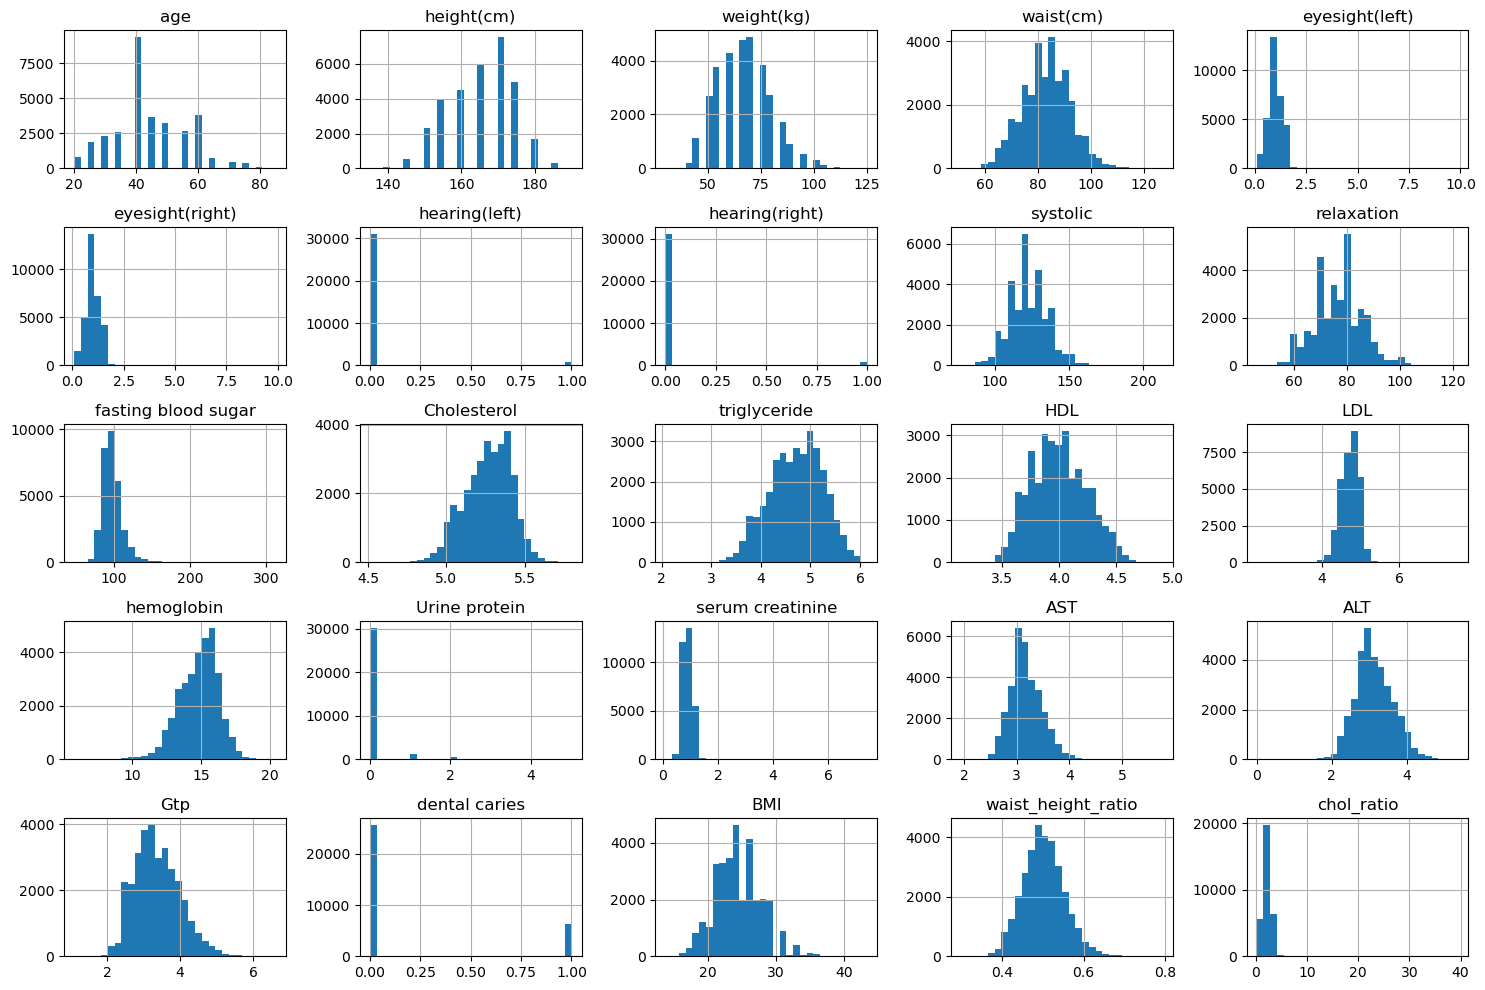

In [464]:
X_test['BMI'] = X_test['weight(kg)'] / ((X_test['height(cm)'] / 100) **2)
X_test['waist_height_ratio'] = X_test['waist(cm)'] / X_test['height(cm)']
X_test['chol_ratio'] = X_test['LDL'] / X_test['HDL']
X_test = duplicates_nan(X_test)
X_test = recoding(X_test)
X_test = log_func(X_test)
X_test[columns_scale] = scaler.transform(X_test[columns_scale])
X_test

**We have completed the preprocessing of the test sample and have moved on to creating the LOGISTIC REGRESSION model, its training and predictions.**

In [468]:
model = LogisticRegression(solver='liblinear', random_state=42)

In [471]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_test)

**Let's evaluate the prediction quality on the test set using data that has undergone standard preprocessing (standardization, logarithmic transformation, reencoding, adding new features).**

In [474]:
accuracy_prepross = accuracy_score(y_test, y_train_pred)
precision_prepross = precision_score(y_test, y_train_pred)
recall_prepross = recall_score(y_test, y_train_pred)
f1_prepross = f1_score(y_test, y_train_pred)
roc_auc_prepross = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy_prepross}')
print(f'Precision: {precision_prepross}')
print(f'Recall: {recall_prepross}')
print(f'F1 Score: {f1_prepross}')
print(f'ROC AUC: {roc_auc_prepross}')

Accuracy: 0.7573464774582443
Precision: 0.7085406859448554
Recall: 0.7562989017299547
F1 Score: 0.7316412624561647
ROC AUC: 0.8380540262745853


**Conclusion: The model demonstrates average performance. We used cross-validation to select the best model parameters. However, at this stage, the model with different parameters did not show significant improvement in metrics (all improvements were in the range of 0.01%), so fine-tuning was excluded from this file.**

**Note: Adding new features showed a slight improvement (compared to the baseline model) in accuracy and a comparable decrease in some other metrics. It was decided to keep these features for the purpose of further building a polynomial logistic regression model.**


**Additionally, we will explore the POLYNOMIAL model, which raises features to a power in order to find nonlinear relationships.**

**Upon re-evaluating the polynomial model, it was decided to first check for class imbalance.**

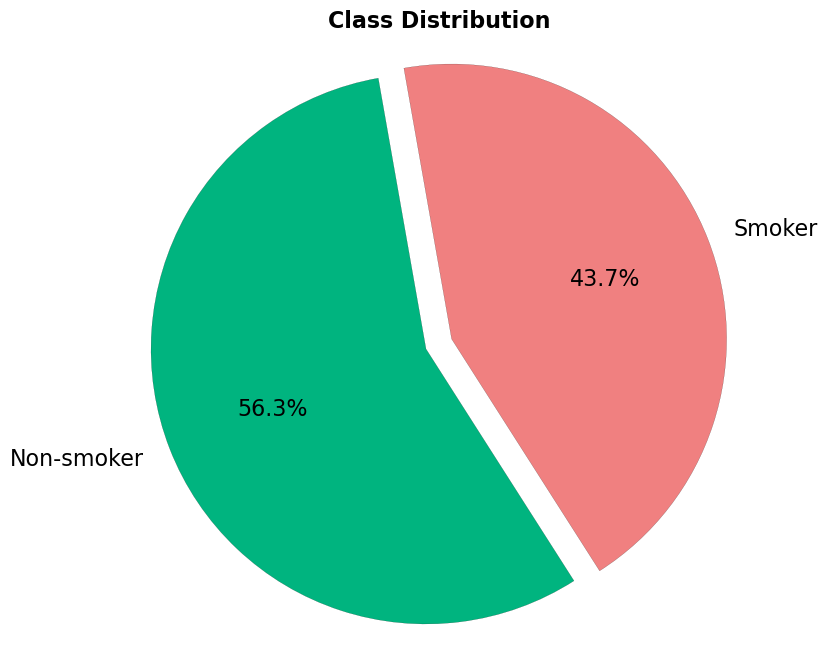

In [476]:
target_counts = y_train.value_counts()

plt.figure(figsize=(8, 8))

explode = (0, 0.1)

plt.pie(
    target_counts, 
    labels=['Non-smoker', 'Smoker'], 
    autopct='%1.1f%%', 
    startangle=100, 
    colors=['#00B47F', 'lightcoral'], 
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.1},
    shadow=False,
    textprops={'fontsize': 16}
)

plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.savefig('classes.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()



**As can be seen, there is no significant imbalance, but we will test SMOTE, which can add synthetic neighbors for the smoker class to help the model learn better.**

In [479]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [480]:
columns_polynome = ['hemoglobin', 'height(cm)', 'weight(kg)', 'Gtp', 'Cholesterol', 'BMI', 'waist_height_ratio',
       'chol_ratio', 'systolic',
       'relaxation', 'age', 'AST',
       'ALT', 'dental caries', 'triglyceride', 'HDL', 'LDL']

**Next, we will train a POLYNOMIAL logistic regression model and also tune the optimal parameters for logistic regression (the parameter selection process is excluded from the file to reduce the document size).**

In [482]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


model2 = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(solver='lbfgs', max_iter=10000, C=0.1, class_weight='balanced'))
model2.fit(X_resampled[columns_polynome], y_resampled)
y_train_pred_2 = model2.predict(X_resampled[columns_polynome])
accuracy_2 = accuracy_score(y_resampled, y_train_pred_2)
precision_2 = precision_score(y_resampled, y_train_pred_2)
recall_2 = recall_score(y_resampled, y_train_pred_2)
f1_2 = f1_score(y_resampled, y_train_pred_2)
roc_auc_2 = roc_auc_score(y_resampled, model2.predict_proba(X_resampled[columns_polynome])[:, 1])


print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
print(f'F1 Score: {f1_2}')
print(f'ROC AUC: {roc_auc_2}')

Accuracy: 0.783090594570464
Precision: 0.7427419644245606
Recall: 0.8662007198459865
F1 Score: 0.7997346711403345
ROC AUC: 0.8570769789676826


**Conclusion: For training the POLYNOMIAL model, we used almost all the features that we had the processing power to handle. We observe an improvement in the model's performance. We assume that the relationship between a number of features and the target variable may be nonlinear.**

**We will also test the model on the validation set to ensure that the model has not overfitted.**

In [487]:
y_test_pred3 = model2.predict(X_test[columns_polynome])
accuracy_3 = accuracy_score(y_test, y_test_pred3)
precision_3 = precision_score(y_test, y_test_pred3)
recall_3 = recall_score(y_test, y_test_pred3)
f1_3 = f1_score(y_test, y_test_pred3)
roc_auc_3 = roc_auc_score(y_test, model2.predict_proba(X_test[columns_polynome])[:, 1])


print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision_3}')
print(f'Recall: {recall_3}')
print(f'F1 Score: {f1_3}')
print(f'ROC AUC: {roc_auc_3}')

Accuracy: 0.7649441165389929
Precision: 0.6856846473029046
Recall: 0.8540664704615606
F1 Score: 0.7606687338170891
ROC AUC: 0.8490739457241354


**The model started predicting class 1 more often (maybe this is affection of SMOTE). Therefore, the polynomial logistic regression model shows a positive trend in predictive capability, but most likely, additional work on class imbalance is required, apart from SMOTE.**

**Let's try other tools. For now, let's record the metrics we already have**

**Let's try trees**

**Random parameter selection showed poor metrics, so we are now trying Optuna.**

In [495]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
import optuna
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 60)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 60)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        criterion=criterion
    )
    
    f1 = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=5).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best parameters: {study.best_params}')

best_params = study.best_params
best_model2 = tree.DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_leaf_nodes=best_params['max_leaf_nodes'],
    criterion=best_params['criterion']
)

[I 2025-05-09 12:05:55,765] A new study created in memory with name: no-name-b2281a98-d724-41c7-9d83-8563120f52d7
[I 2025-05-09 12:05:57,219] Trial 0 finished with value: 0.7489718706174331 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 35, 'max_leaf_nodes': 55, 'criterion': 'gini'}. Best is trial 0 with value: 0.7489718706174331.
[I 2025-05-09 12:05:58,601] Trial 1 finished with value: 0.7489718706174331 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 35, 'max_leaf_nodes': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.7489718706174331.
[I 2025-05-09 12:05:59,736] Trial 2 finished with value: 0.7458195619752993 and parameters: {'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 28, 'max_leaf_nodes': 57, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7489718706174331.
[I 2025-05-09 12:06:01,113] Trial 3 finished with value: 0.7489303148321298 and parameters: {'max_depth': 5, 'min_samples_split': 11, '

Best parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 25, 'max_leaf_nodes': 55, 'criterion': 'entropy'}


In [496]:
best_model2.fit(X_train, y_train)

y_train_pred_opt = best_model2.predict(X_train)


print(f"F1 on training dataset: {f1_score(y_train, y_train_pred_opt, average='weighted')}")

F1 on training dataset: 0.7582926304221969


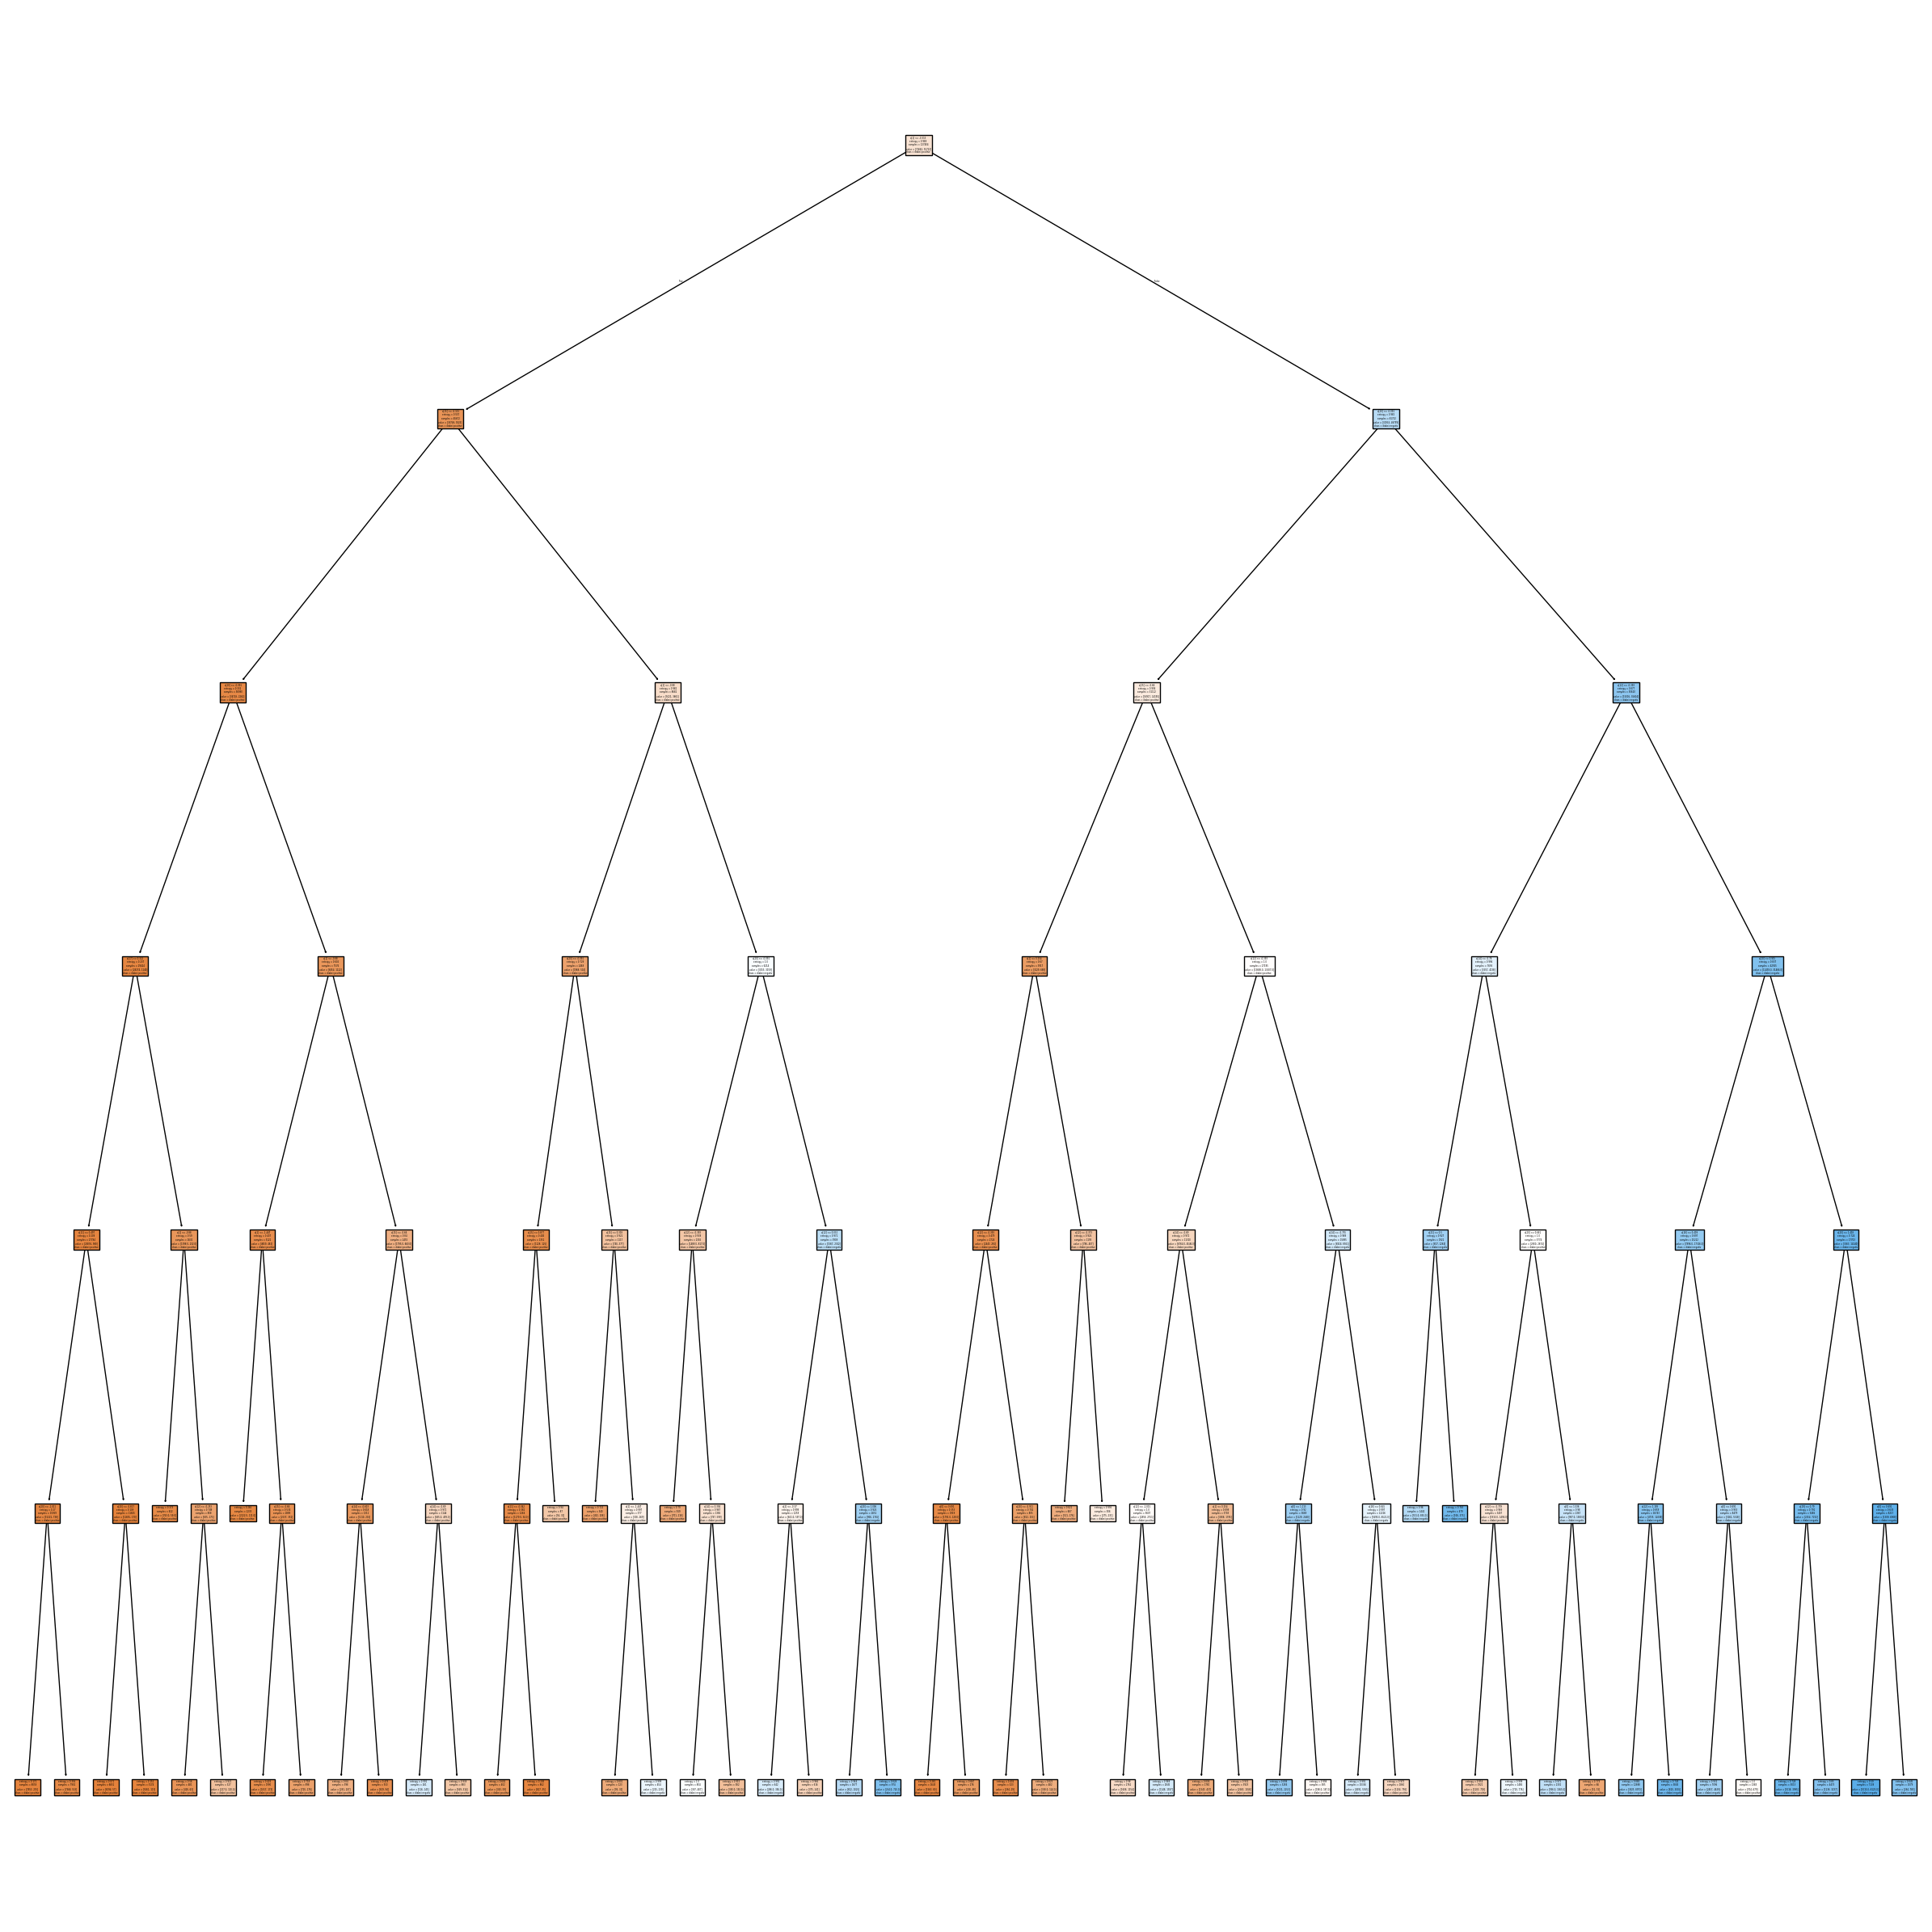

In [497]:
plt.figure(figsize=(24, 24))
tree.plot_tree(best_model2, class_names=['diabet positive', 'diabet negativ'], filled=True)
plt.tight_layout()
None

In [504]:
accuracy_train_opt = accuracy_score(y_train, y_train_pred_opt)
precision_train_opt = precision_score(y_train, y_train_pred_opt)
recall_train_opt = recall_score(y_train, y_train_pred_opt)
roc_auc_train_opt = roc_auc_score(y_train, best_model2.predict_proba(X_train)[:, 1])

print(f'Accuracy for the training set: {accuracy_train_opt}')
print(f'Precision for the training set: {precision_train_opt}')
print(f'Recall for the training set: {recall_train_opt}')
print(f'ROC AUC for the training set: {roc_auc_train_opt}')


Accuracy for the training set: 0.7576920661831653
Precision for the training set: 0.681269785694487
Recall for the training set: 0.8380711388679516
ROC AUC for the training set: 0.8358517213223525


**No improvement in metrics was observed. Let's try the ensemble XGBoost model with decision trees**


In [508]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

y_train = y_train.ravel()
y_test = y_test.ravel()

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 50),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # handle class imbalance
    }
    model4 = XGBClassifier(**param)
    model4.fit(X_train, y_train)
    y_pred4 = model4.predict(X_test)
    return f1_score(y_test, y_pred4) 


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best F1-score during training:", study.best_value)

best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

f1_best = f1_score(y_test, y_test_pred)
accuracy_best = accuracy_score(y_test, y_test_pred)

print(f'F1 Score of best model: {f1_best}')
print(f'Accuracy of best model: {accuracy_best}')


/tmp/ipykernel_83093/1484381328.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()
/tmp/ipykernel_83093/1484381328.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()
[I 2025-05-09 12:08:41,379] A new study created in memory with name: no-name-0b483a0e-29fa-4cd0-9737-081a2f7126df
[I 2025-05-09 12:08:41,929] Trial 0 finished with value: 0.7698027804720337 and parameters: {'max_depth': 3, 'learning_rate': 0.2580405513194813, 'n_estimators': 445, 'colsample_bytree': 0.6164885884228724, 'min_child_weight': 1, 'subsample': 0.8380767644916693, 'colsample_bylevel': 0.9356361178547113, 'colsample_bynode': 0.6280331781983931, 'max_delta_step': 14}. Best is trial 0 with value: 0.7698027804720337.
[I 2025-05-

Best parameters: {'max_depth': 6, 'learning_rate': 0.051041136529149156, 'n_estimators': 352, 'colsample_bytree': 0.7425189287112635, 'min_child_weight': 6, 'subsample': 0.8636336555100195, 'colsample_bylevel': 0.8691140134107425, 'colsample_bynode': 0.8969225025388062, 'max_delta_step': 8}
Best F1-score during training: 0.7726718439124575
F1 Score of best model: 0.7654354273389053
Accuracy of best model: 0.7814893884214492


In [510]:
accuracy_test_xgb = accuracy_score(y_test, y_test_pred)
precision_test_xgb = precision_score(y_test, y_test_pred)
recall_test_xgb = recall_score(y_test, y_test_pred)
roc_auc_test_xgb = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f'Accuracy for test set: {accuracy_test_xgb}')
print(f'Precision for test set: {precision_test_xgb}')
print(f'Recall for test set: {recall_test_xgb}')
print(f'F1 Score for test set: {f1_best}')
print(f'ROC AUC for test set: {roc_auc_test_xgb}')



Accuracy for test set: 0.7814893884214492
Precision for test set: 0.7214281176545327
Recall for test set: 0.8151604335654297
F1 Score for test set: 0.7654354273389053
ROC AUC for test set: 0.8646729554248312


**Again, we observe an improvement in metrics — the gap between Precision and Recall is narrowing, which indicates that boosting is doing a good job balancing the classes.**

**Let’s see how the voting classifier performs — we will use three types of boosting models: XGBoost, CatBoost, and LightGBM**

In [515]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

xgb_model = XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_catboost = catboost_model.predict(X_test)

y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost)
recall_catboost = recall_score(y_test, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_test, y_pred_proba_catboost)

voting_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model)
], voting='soft')


voting_model.fit(X_train, y_train)


y_pred_vote = voting_model.predict(X_test)
y_pred_proba_vote = voting_model.predict_proba(X_test)[:, 1]


accuracy_vote = accuracy_score(y_test, y_pred_vote)
f1_vote = f1_score(y_test, y_pred_vote)
precision_vote = precision_score(y_test, y_pred_vote)
recall_vote = recall_score(y_test, y_pred_vote)
roc_auc_vote = roc_auc_score(y_test, y_pred_proba_vote)


print(f"XGBoost - Accuracy: {accuracy_xgb}, F1-Score: {f1_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, ROC AUC: {roc_auc_xgb}")
print(f"LightGBM - Accuracy: {accuracy_lgbm}, F1-Score: {f1_lgbm}, Precision: {precision_lgbm}, Recall: {recall_lgbm}, ROC AUC: {roc_auc_lgbm}")
print(f"CatBoost - Accuracy: {accuracy_catboost}, F1-Score: {f1_catboost}, Precision: {precision_catboost}, Recall: {recall_catboost}, ROC AUC: {roc_auc_catboost}")
print(f"Voting Classifier - Accuracy: {accuracy_vote}, F1-Score: {f1_vote}, Precision: {precision_vote}, Recall: {recall_vote}, ROC AUC: {roc_auc_vote}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251865
[LightGBM] [Info] Start training from score -0.251865
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [516]:
print(f'Accuracy for test set: {accuracy_vote}')
print(f'Precision for test set: {precision_vote}')
print(f'Recall for test set: {recall_vote}')
print(f'F1 Score for test set: {f1_vote}')
print(f'ROC AUC for test set: {roc_auc_vote}')


Accuracy for test set: 0.7815521788270752
Precision for test set: 0.7223391365346598
Recall for test set: 0.8130787452444189
F1 Score for test set: 0.7650276914764285
ROC AUC for test set: 0.8655812760020529


**There are no significant overall improvements, because as the results show, the main contribution is most likely made by XGBoost, which already achieved the best metrics earlier.**

**Let's try using this boosting models together with the polynomial model.**

In [526]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

polymod = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = polymod.fit_transform(X_train)
X_test_poly = polymod.transform(X_test)

poly_features = polymod.get_feature_names_out(X_train.columns)

X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_features)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_features)

xgb_model1 = XGBClassifier(random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
lgbm_model1 = LGBMClassifier(random_state=42, class_weight='balanced')
catboost_model1 = CatBoostClassifier(random_state=42, verbose=0, class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)])

xgb_model1.fit(X_train_poly_df, y_train)
lgbm_model1.fit(X_train_poly_df, y_train)
catboost_model1.fit(X_train_poly_df, y_train)

y_pred_xgb1 = xgb_model1.predict(X_test_poly_df)
y_pred_proba_xgb1 = xgb_model1.predict_proba(X_test_poly_df)[:, 1]

y_pred_lgbm1 = lgbm_model1.predict(X_test_poly_df)
y_pred_proba_lgbm1 = lgbm_model1.predict_proba(X_test_poly_df)[:, 1]

y_pred_catboost1 = catboost_model1.predict(X_test_poly_df)
y_pred_proba_catboost1 = catboost_model1.predict_proba(X_test_poly_df)[:, 1]

accuracy_xgb1 = accuracy_score(y_test, y_pred_xgb1)
f1_xgb1 = f1_score(y_test, y_pred_xgb1)
precision_xgb1 = precision_score(y_test, y_pred_xgb1)
recall_xgb1 = recall_score(y_test, y_pred_xgb1)

accuracy_lgbm1 = accuracy_score(y_test, y_pred_lgbm1)
f1_lgbm1 = f1_score(y_test, y_pred_lgbm1)
precision_lgbm1 = precision_score(y_test, y_pred_lgbm1)
recall_lgbm1 = recall_score(y_test, y_pred_lgbm1)

accuracy_catboost1 = accuracy_score(y_test, y_pred_catboost1)
f1_catboost1 = f1_score(y_test, y_pred_catboost1)
precision_catboost1 = precision_score(y_test, y_pred_catboost1)
recall_catboost1 = recall_score(y_test, y_pred_catboost1)

voting_model1 = VotingClassifier(estimators=[
    ('xgb', xgb_model1),
    ('lgbm', lgbm_model1),
    ('catboost', catboost_model1)
], voting='soft')

voting_model1.fit(X_train_poly_df, y_train)

y_pred_vote1 = voting_model1.predict(X_test_poly_df)
y_pred_proba_vote1 = voting_model1.predict_proba(X_test_poly_df)[:, 1]

accuracy_vote1 = accuracy_score(y_test, y_pred_vote1)
f1_vote1 = f1_score(y_test, y_pred_vote1)
precision_vote1 = precision_score(y_test, y_pred_vote1)
recall_vote1 = recall_score(y_test, y_pred_vote1)
roc_auc_vote1 = roc_auc_score(y_test, y_pred_proba_vote1)


print(f"XGBoost - Accuracy: {accuracy_xgb1}, F1-Score: {f1_xgb1}, Precision: {precision_xgb1}, Recall: {recall_xgb1}")
print(f"LightGBM - Accuracy: {accuracy_lgbm1}, F1-Score: {f1_lgbm1}, Precision: {precision_lgbm1}, Recall: {recall_lgbm1}")
print(f"CatBoost - Accuracy: {accuracy_catboost1}, F1-Score: {f1_catboost1}, Precision: {precision_catboost1}, Recall: {recall_catboost1}")
print(f"Voting Classifier - Accuracy: {accuracy_vote1}, F1-Score: {f1_vote1}, Precision: {precision_vote1}, Recall: {recall_vote1}, ROC AUC: {roc_auc_vote1}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67237
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 350
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67237
[LightGBM] [Info] Number of data points in the train set: 127404, number of

In [528]:
print(f'Accuracy on test set: {accuracy_vote1}')
print(f'Precision on test set: {precision_vote1}')
print(f'Recall on test set: {recall_vote1}')
print(f'F1 Score on test set: {f1_vote1}')
print(f'ROC AUC on test set: {roc_auc_vote1}')


Accuracy on test set: 0.7764661559713676
Precision on test set: 0.6989775051124745
Recall on test set: 0.8587323235948604
F1 Score on test set: 0.7706628873284803
ROC AUC on test set: 0.8637110614415429


**Precision has dropped. We're going to remove the polynomial features and instead focus on tuning the hyperparameters of each individual boosting model.**

**Let's try focusing the boosting models on the F1 metric, since it accounts for the balance between false positives (precision) and false negatives (recall). We'll also include the number of trees.**

In [533]:
xgb_model2 = XGBClassifier(
    random_state=42, 
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    eval_metric='aucpr',
    n_estimators=1000,
)


lgbm_model2 = LGBMClassifier(
    random_state=42, 
    class_weight='balanced',
    metric='f1'
)


catboost_model2 = CatBoostClassifier(
    random_state=42, 
    verbose=0, 
    class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)], 
    loss_function='Logloss', 
    eval_metric='F1'
)


xgb_model2.fit(X_train, y_train)
lgbm_model2.fit(X_train, y_train)
catboost_model2.fit(X_train, y_train)


y_pred_xgb2 = xgb_model2.predict(X_test)
y_pred_proba_xgb2 = xgb_model2.predict_proba(X_test)[:, 1]

y_pred_lgbm2 = lgbm_model2.predict(X_test)
y_pred_proba_lgbm2 = lgbm_model2.predict_proba(X_test)[:, 1]

y_pred_catboost2 = catboost_model2.predict(X_test)
y_pred_proba_catboost2 = catboost_model2.predict_proba(X_test)[:, 1]

accuracy_xgb2 = accuracy_score(y_test, y_pred_xgb2)
f1_xgb2 = f1_score(y_test, y_pred_xgb2)
precision_xgb2 = precision_score(y_test, y_pred_xgb2)
recall_xgb2 = recall_score(y_test, y_pred_xgb2)

accuracy_lgbm2 = accuracy_score(y_test, y_pred_lgbm2)
f1_lgbm2 = f1_score(y_test, y_pred_lgbm2)
precision_lgbm2 = precision_score(y_test, y_pred_lgbm2)
recall_lgbm2 = recall_score(y_test, y_pred_lgbm2)

accuracy_catboost2 = accuracy_score(y_test, y_pred_catboost2)
f1_catboost2 = f1_score(y_test, y_pred_catboost2)
precision_catboost2 = precision_score(y_test, y_pred_catboost2)
recall_catboost2 = recall_score(y_test, y_pred_catboost2)


voting_model2 = VotingClassifier(estimators=[
    ('xgb', xgb_model2),
    ('lgbm', lgbm_model2),
    ('catboost', catboost_model2)
], voting='soft')  

voting_model2.fit(X_train, y_train)

y_pred_vote2 = voting_model2.predict(X_test)
y_pred_proba_vote2 = voting_model2.predict_proba(X_test)[:, 1]


accuracy_vote2 = accuracy_score(y_test, y_pred_vote2)
f1_vote2 = f1_score(y_test, y_pred_vote2)
precision_vote2 = precision_score(y_test, y_pred_vote2)
recall_vote2 = recall_score(y_test, y_pred_vote2)
roc_auc_vote2 = roc_auc_score(y_test, y_pred_proba_vote2)


print(f"XGBoost - Accuracy: {accuracy_xgb2}, F1-Score: {f1_xgb2}, Precision: {precision_xgb2}, Recall: {recall_xgb2}")
print(f"LightGBM - Accuracy: {accuracy_lgbm2}, F1-Score: {f1_lgbm2}, Precision: {precision_lgbm2}, Recall: {recall_lgbm2}")
print(f"CatBoost - Accuracy: {accuracy_catboost2}, F1-Score: {f1_catboost2}, Precision: {precision_catboost2}, Recall: {recall_catboost2}")
print(f"Voting Classifier - Accuracy: {accuracy_vote2}, F1-Score: {f1_vote2}, Precision: {precision_vote2}, Recall: {recall_vote2}, ROC AUC: {roc_auc_vote2}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [534]:
print(f'Accuracy on test set: {accuracy_vote2}')
print(f'Precision on test set: {precision_vote2}')
print(f'Recall on test set: {recall_vote2}')
print(f'F1 Score on test set: {f1_vote2}')
print(f'ROC AUC on test set: {roc_auc_vote2}')

Accuracy on test set: 0.7798882330779857
Precision on test set: 0.7062962079656571
Recall on test set: 0.8503337879549207
F1 Score on test set: 0.7716509787317201
ROC AUC on test set: 0.8657816785928811


**Finally, let's try applying the XGBoost parameters that were previously tuned using Optuna.**

In [537]:
xgb_model3 = XGBClassifier(
    random_state=42, 
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    eval_metric='aucpr',
    n_estimators=1000,
    max_depth = 3, 
    learning_rate = 0.286556051096985, 
    colsample_bytree = 0.6780794857495402,
    min_child_weight = 7,
    subsample = 0.8607954635659916, 
    colsample_bylevel = 0.7442931921834796, 
    colsample_bynode = 0.8916954166069389, 
    max_delta_step = 42
)


lgbm_model3 = LGBMClassifier(
    random_state=42, 
    class_weight='balanced',
    metric='f1'
)


catboost_model3 = CatBoostClassifier(
    random_state=42, 
    verbose=0, 
    class_weights=[1, (len(y_train) - sum(y_train)) / sum(y_train)], 
    loss_function='Logloss', 
    eval_metric='F1'
)


xgb_model3.fit(X_train, y_train)
lgbm_model3.fit(X_train, y_train)
catboost_model3.fit(X_train, y_train)


y_pred_xgb3 = xgb_model3.predict(X_test)
y_pred_proba_xgb3 = xgb_model3.predict_proba(X_test)[:, 1]

y_pred_lgbm3 = lgbm_model3.predict(X_test)
y_pred_proba_lgbm3 = lgbm_model3.predict_proba(X_test)[:, 1]

y_pred_catboost3 = catboost_model3.predict(X_test)
y_pred_proba_catboost3 = catboost_model3.predict_proba(X_test)[:, 1]

accuracy_xgb3 = accuracy_score(y_test, y_pred_xgb3)
f1_xgb3 = f1_score(y_test, y_pred_xgb3)
precision_xgb3 = precision_score(y_test, y_pred_xgb3)
recall_xgb3 = recall_score(y_test, y_pred_xgb3)

accuracy_lgbm3 = accuracy_score(y_test, y_pred_lgbm3)
f1_lgbm3 = f1_score(y_test, y_pred_lgbm3)
precision_lgbm3 = precision_score(y_test, y_pred_lgbm3)
recall_lgbm3 = recall_score(y_test, y_pred_lgbm3)

accuracy_catboost3 = accuracy_score(y_test, y_pred_catboost3)
f1_catboost3 = f1_score(y_test, y_pred_catboost3)
precision_catboost3 = precision_score(y_test, y_pred_catboost3)
recall_catboost3 = recall_score(y_test, y_pred_catboost3)


voting_model3 = VotingClassifier(estimators=[
    ('xgb', xgb_model3),
    ('lgbm', lgbm_model3),
    ('catboost', catboost_model3)
], voting='soft')  

voting_model3.fit(X_train, y_train)

y_pred_vote3 = voting_model3.predict(X_test)
y_pred_proba_vote3 = voting_model3.predict_proba(X_test)[:, 1]


accuracy_vote3 = accuracy_score(y_test, y_pred_vote3)
f1_vote3 = f1_score(y_test, y_pred_vote3)
precision_vote3 = precision_score(y_test, y_pred_vote3)
recall_vote3 = recall_score(y_test, y_pred_vote3)
roc_auc_vote3 = roc_auc_score(y_test, y_pred_proba_vote3)


print(f"XGBoost - Accuracy: {accuracy_xgb3}, F1-Score: {f1_xgb3}, Precision: {precision_xgb3}, Recall: {recall_xgb3}")
print(f"LightGBM - Accuracy: {accuracy_lgbm3}, F1-Score: {f1_lgbm3}, Precision: {precision_lgbm3}, Recall: {recall_lgbm3}")
print(f"CatBoost - Accuracy: {accuracy_catboost3}, F1-Score: {f1_catboost3}, Precision: {precision_catboost3}, Recall: {recall_catboost3}")
print(f"Voting Classifier - Accuracy: {accuracy_vote3}, F1-Score: {f1_vote3}, Precision: {precision_vote3}, Recall: {recall_vote3}, ROC AUC: {roc_auc_vote3}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

Let's recall that the metrics on the baseline model after data preprocessing were as follows:

In [539]:
print(f'Accuracy: {accuracy_prepross}')
print(f'Precision: {precision_prepross}')
print(f'Recall: {recall_prepross}')
print(f'F1 Score: {f1_prepross}')
print(f'ROC AUC: {roc_auc_prepross}')

Accuracy: 0.7573464774582443
Precision: 0.7085406859448554
Recall: 0.7562989017299547
F1 Score: 0.7316412624561647
ROC AUC: 0.8380540262745853


**SO, THE BEST METRICS ON THE PROJECT**

In [541]:
print(f'Accuracy on test set: {accuracy_vote3}')
print(f'Precision on test set: {precision_vote3}')
print(f'Recall on test set: {recall_vote3}')
print(f'F1 Score on test set: {f1_vote3}')
print(f'ROC AUC on test set: {roc_auc_vote3}')

Accuracy on test set: 0.7787266105739044
Precision on test set: 0.701386857042542
Recall on test set: 0.8603833177804896
F1 Score on test set: 0.7727917472598324
ROC AUC on test set: 0.8667088449925735


The voting model demonstrated an overall improvement, especially in terms of Recall, meaning it became better at detecting all positive instances, with fewer false negatives and more true positives. However, this came with some decrease in Precision. This could be attributed to models like XGBoost, CatBoost, and LightGBM, which tend to perform better by increasing sensitivity to the positive class (increasing Recall), but sometimes lose in accuracy (Precision). The improvement in F1 Score and ROC AUC suggests that the overall ability to classify data improved, despite small changes in individual metrics.

**Let's observe results on graphs**

Baseline Model (Raw):
Accuracy: 0.7454163003893005
Precision: 0.7036353696870302
Recall: 0.731892813988201
F1 Score: 0.717485977075567
ROC AUC: 0.8322575753891877

Preprocessed Feature Model:
Accuracy: 0.7573464774582443
Precision: 0.7085406859448554
Recall: 0.7562989017299547
F1 Score: 0.7316412624561647
ROC AUC: 0.8380540262745853

Polynomial Model:
Accuracy: 0.7649441165389929
Precision: 0.6856846473029046
Recall: 0.8540664704615606
F1 Score: 0.7606687338170891
ROC AUC: 0.8490739457241354

Voting Model with Boosting:
Accuracy: 0.7787266105739044
Precision: 0.701386857042542
Recall: 0.8603833177804896
F1 Score: 0.7727917472598324
ROC AUC: 0.8667088449925735


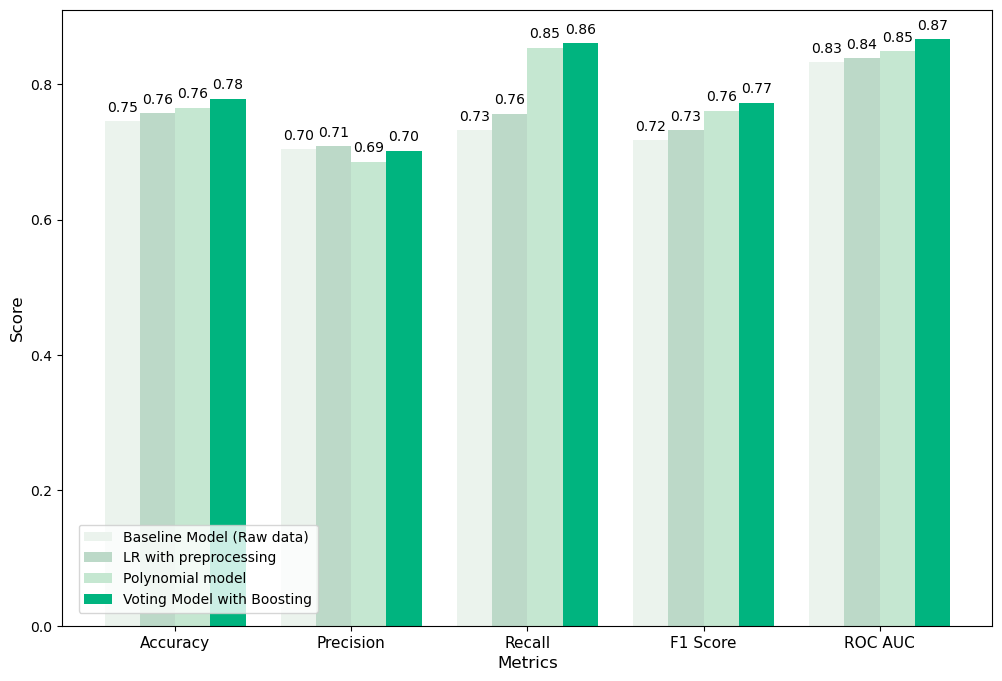

In [558]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
raw_values = [raw_accuracy, raw_precision, raw_recall, raw_f1, raw_roc_auc]
processed_values = [accuracy_prepross, precision_prepross, recall_prepross, f1_prepross, roc_auc_prepross]
polynomial_values = [accuracy_3, precision_3, recall_3, f1_3, roc_auc_3]
voting_values = [accuracy_vote3, precision_vote3, recall_vote3, f1_vote3, roc_auc_vote3]
print("Baseline Model (Raw):")
for metric, value in zip(metrics, raw_values):
    print(f'{metric}: {value}')

print("\nPreprocessed Feature Model:")
for metric, value in zip(metrics, processed_values):
    print(f'{metric}: {value}')

print("\nPolynomial Model:")
for metric, value in zip(metrics, polynomial_values):
    print(f'{metric}: {value}')

print("\nVoting Model with Boosting:")
for metric, value in zip(metrics, voting_values):
    print(f'{metric}: {value}')
x = np.arange(len(metrics))

width = 0.2


colors = sns.light_palette('seagreen', n_colors=5)


fig, ax = plt.subplots(figsize=(12, 8))


bars1 = ax.bar(x - 1.5 * width, raw_values, width, label='Baseline Model (Raw data)', color=colors[0])
bars2 = ax.bar(x - 0.5 * width, processed_values, width, label='LR with preprocessing', color=colors[1])
bars3 = ax.bar(x + 0.5 * width, polynomial_values, width, label='Polynomial model', color='#c5e7d1')
bars4 = ax.bar(x + 1.5 * width, voting_values, width, label='Voting Model with Boosting', color='#00B47F')


ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)


ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.01), frameon=True, fontsize=10)


for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10)


plt.savefig('compar.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)


plt.show()


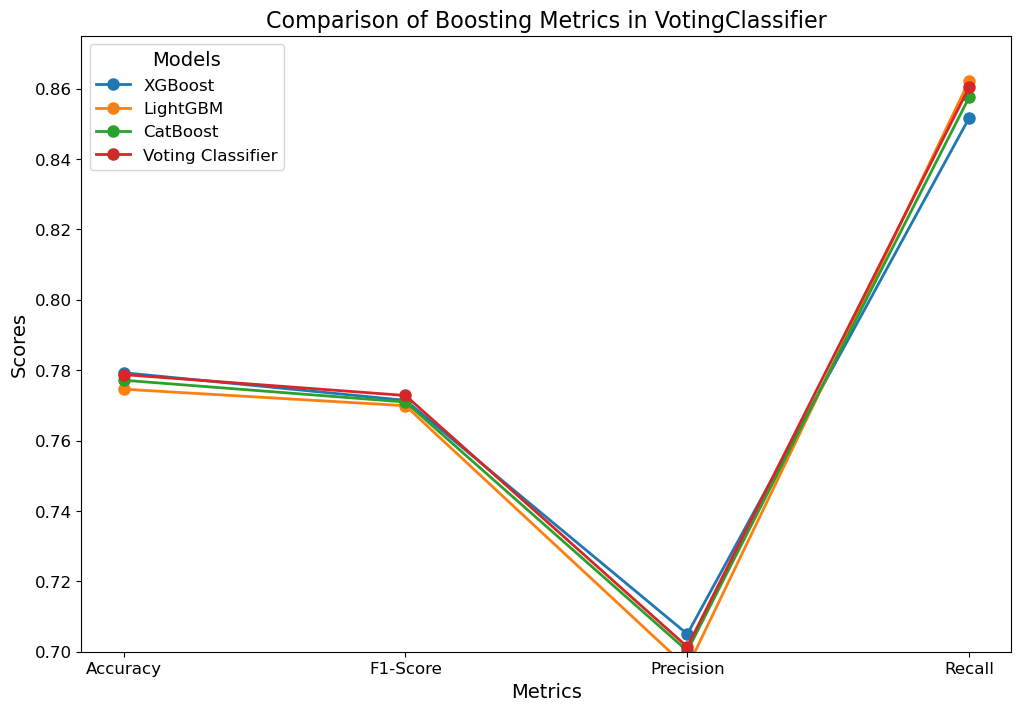

In [560]:
import matplotlib.pyplot as plt
import numpy as np

models = ['XGBoost', 'LightGBM', 'CatBoost', 'Voting Classifier']
accuracy = [accuracy_xgb3, accuracy_lgbm3, accuracy_catboost3, accuracy_vote3]
f1 = [f1_xgb3, f1_lgbm3, f1_catboost3, f1_vote3]
precision = [precision_xgb3, precision_lgbm3, precision_catboost3, precision_vote3]
recall = [recall_xgb3, recall_lgbm3, recall_catboost3, recall_vote3]


metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
metric_values = np.array([accuracy, f1, precision, recall])


plt.figure(figsize=(12, 8))  


for i, model in enumerate(models):
    plt.plot(metrics, metric_values[:, i], label=model, linestyle='-', marker='o', linewidth=2, markersize=8)


plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of Boosting Metrics in VotingClassifier', fontsize=16)


plt.ylim(0.7, 0.875)


plt.legend(title='Models', fontsize=12, title_fontsize=14)


plt.xticks(fontsize=12)

plt.yticks(fontsize=12)

plt.savefig('boost.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()


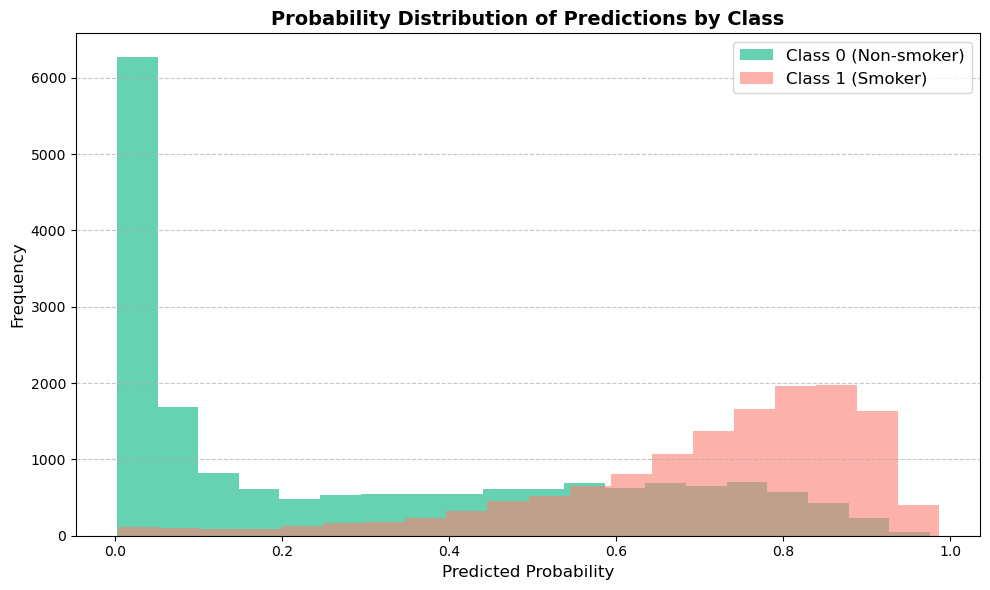

In [562]:
plt.figure(figsize=(10, 6))

plt.hist(y_pred_proba_vote3[y_test == 0], bins=20, alpha=0.6, label="Class 0 (Non-smoker)", color="#00B47F")
plt.hist(y_pred_proba_vote3[y_test == 1], bins=20, alpha=0.6, label="Class 1 (Smoker)", color="salmon")

plt.title("Probability Distribution of Predictions by Class", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig('dictrib.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()


In [564]:
import joblib

MODEL_FILE = "voting_model3.pkl"

joblib.dump(voting_model3, MODEL_FILE)

print(f"Model saved to {MODEL_FILE}")

Model saved to voting_model3.pkl


After all, let's make predictions on test.csv data

In [613]:
raw_df_test

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
159256,40,165,70,84.0,1.2,1.2,1,1,130,89,...,186,49,115,14.2,1,0.9,19,25,32,0
159257,80,160,60,93.0,1.0,1.0,2,2,144,72,...,158,35,104,13.0,1,1.1,20,12,24,0
159258,60,170,70,86.5,0.6,0.7,1,1,117,75,...,173,39,88,15.4,1,1.4,38,60,36,0
159259,40,160,50,67.0,0.3,0.4,1,1,116,62,...,47,75,128,14.5,1,0.6,25,18,10,1
159260,40,170,75,89.4,1.0,0.9,1,1,132,94,...,100,39,123,16.5,1,1.0,30,39,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265422,40,165,60,78.0,0.8,0.9,1,1,112,78,...,82,59,149,16.4,1,1.1,24,31,28,0
265423,40,170,85,95.0,1.2,1.2,1,1,130,90,...,186,44,100,16.0,2,1.0,25,31,38,0
265424,35,170,85,89.0,1.2,1.2,1,1,131,86,...,76,53,142,15.9,1,0.8,33,32,24,1


Number of features with missing values: 0
Total number of missing values: 0
Number of all-zero rows: 0
Duplicated rows:
Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, BMI, waist_height_ratio, chol_ratio]
Index: []

[0 rows x 25 columns]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
159256,-0.364999,-0.029406,0.226250,0.111057,0.477983,0.505916,0,0,0.587768,1.346020,...,-0.415237,0,0.042484,-0.832164,0.141132,0.151846,0,0.372369,0.509091,0.218273
159257,3.013882,-0.596624,-0.568290,1.116223,-0.014735,-0.002875,1,1,1.688021,-0.544049,...,-1.253734,0,1.161253,-0.659875,-1.337929,-0.309489,0,-0.303113,0.581250,1.056138
159258,1.324441,0.537811,0.226250,0.390270,-1.000169,-0.766062,0,0,-0.433896,-0.210508,...,0.423260,0,2.839407,1.496054,1.905336,0.340726,0,-0.070260,0.508824,0.096812
159259,-0.364999,-0.596624,-1.362831,-1.787592,-1.739246,-1.529249,0,0,-0.512486,-1.655855,...,-0.205613,0,-1.635670,0.089644,-0.520854,-1.713417,1,-1.463364,0.418750,-0.640768
159260,-0.364999,0.537811,0.623520,0.714157,-0.014735,-0.257271,0,0,0.744947,1.901922,...,1.191882,0,0.601868,0.702045,1.037242,-0.120609,1,0.443623,0.525882,1.300884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265422,-0.364999,-0.029406,-0.568290,-0.559054,-0.507452,-0.257271,0,0,-0.826844,0.123034,...,1.122007,0,1.161253,-0.047473,0.574614,-0.062289,0,-0.718630,0.472727,0.457742
265423,-0.364999,0.537811,1.418060,1.339594,0.477983,0.505916,0,0,0.587768,1.457200,...,0.842508,1,0.601868,0.089644,0.574614,0.427430,0,1.471389,0.558824,0.118705
265424,-0.787359,0.537811,1.418060,0.669483,0.477983,0.505916,0,0,0.666357,1.012478,...,0.772633,0,-0.516901,1.022184,0.638593,-0.309489,1,1.471389,0.523529,0.664122


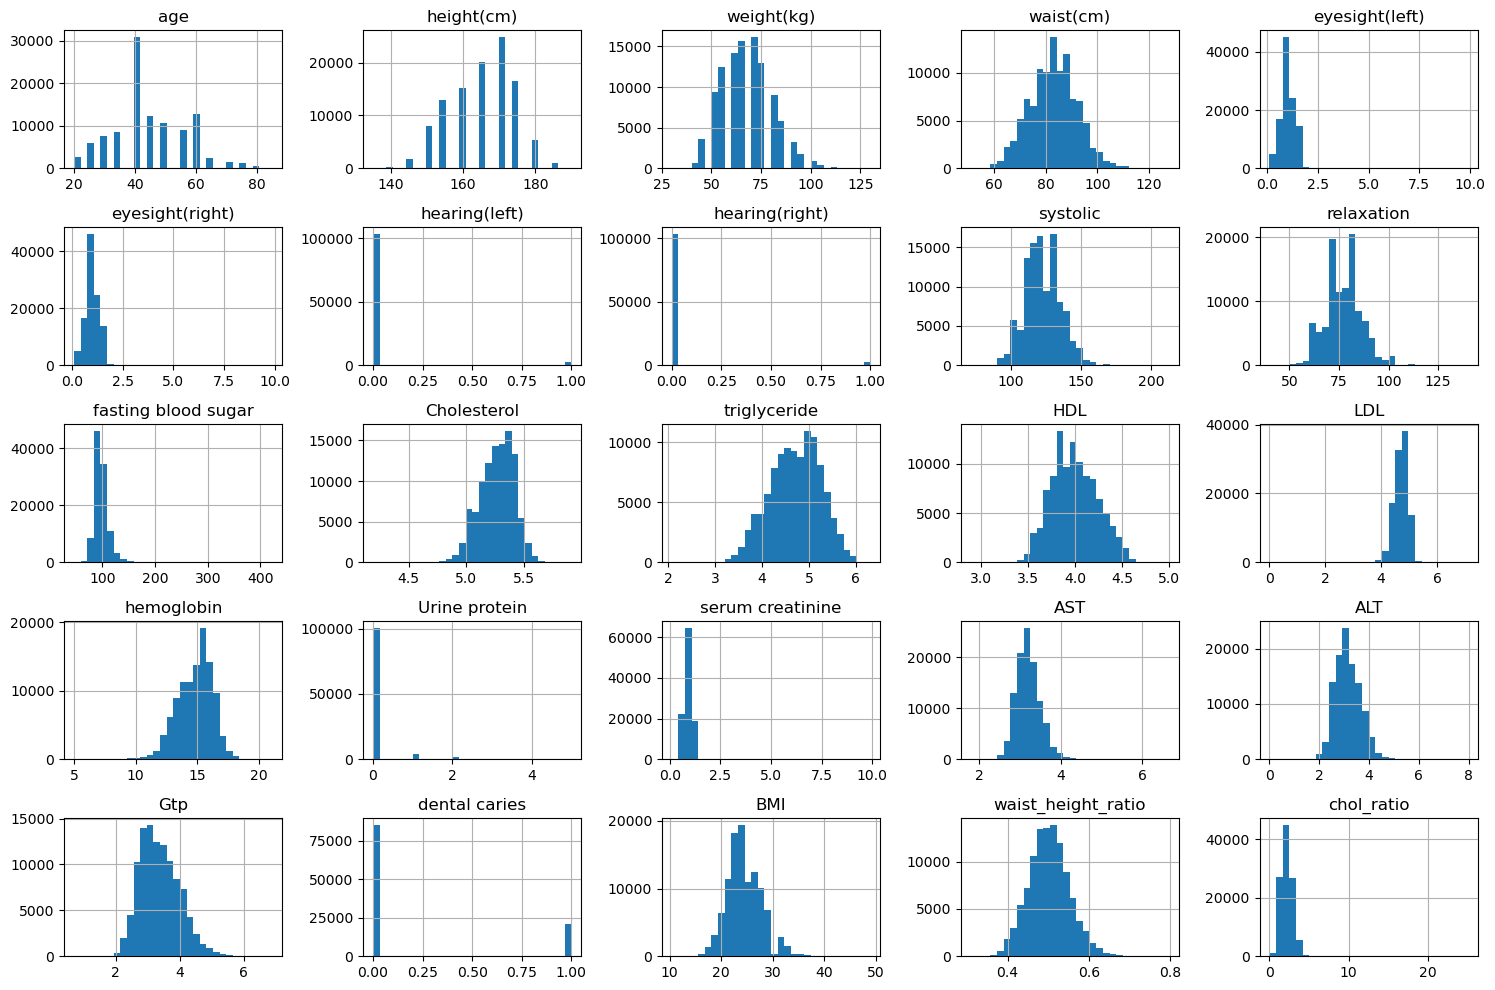

In [617]:
raw_df_test['BMI'] = raw_df_test['weight(kg)'] / ((raw_df_test['height(cm)'] / 100) **2)
raw_df_test['waist_height_ratio'] = raw_df_test['waist(cm)'] / raw_df_test['height(cm)']
raw_df_test['chol_ratio'] = raw_df_test['LDL'] / raw_df_test['HDL']
raw_df_test = duplicates_nan(raw_df_test)
raw_df_test = recoding(raw_df_test)
prep_df_test = log_func(raw_df_test)
prep_df_test[columns_scale] = scaler.transform(prep_df_test[columns_scale])
prep_df_test

In [623]:
y_pred_vote_test = voting_model3.predict(prep_df_test)

submission = pd.DataFrame({
    'id': prep_df_test.index,
    'smoking': y_pred_vote_test
})

submission.to_csv('my_submission.csv', index=False)
